In [1]:
# Makes it easy to use R in jupyter. Just include "%%R" on top of every R cell from now on
%load_ext rpy2.ipython

/home/claudio/anaconda3/envs/M_Essand_2101/lib/python3.6/site-packages/rpy2/ipython/rmagic.py:77: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded (error: No module named 'pandas'), but at least we found `numpy`.
  'but at least we found `numpy`.' % str(ie))


Load libraries:

In [2]:
%%R
suppressMessages(require(Seurat))
suppressMessages(require(Matrix))

library(grid)
library(gridExtra)
library(ggplot2)
library(plyr)
library(pheatmap)
library(dplyr)
library(SeuratDisk)
library(reshape2)
library(EnhancedVolcano)
library(readxl)
library(abind)
library(AUCell)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following object is masked from ‘package:gridExtra’:

    combine


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

R[write to console]: Loading required package: ggrepel



# QC

Load raw, DBEC-corrected counts:

In [3]:
%%R

correction <- "DBEC" # select correction type, DBEC or RSEC
counts.paths <- Sys.glob(file.path("../data/004_CART_data/Library *", paste0("*",correction, "*.csv")))
print(counts.paths)

# read csv files in tables
raw.counts.library1 <- read.table(file=counts.paths[1], sep=",", header = TRUE, row.names="Cell_Index")
raw.counts.library2 <- read.table(file=counts.paths[2], sep=",", header = TRUE, row.names="Cell_Index")
raw.counts.library3 <- read.table(file=counts.paths[3], sep=",", header = TRUE, row.names="Cell_Index")
raw.counts.library4 <- read.table(file=counts.paths[4], sep=",", header = TRUE, row.names="Cell_Index")

# save abseq counts to separate object
abseq.counts.library1 <- raw.counts.library1[,1:6]
# same for CART counts
cart.counts.library1 <- raw.counts.library1[,"CART"]
# RNA counts are put in yet another separate object...
rna.counts.library1 <- raw.counts.library1[,7:465]
# ... from which me make sure to remove the CART column
cart.column <- which(colnames(rna.counts.library1) == "CART")
rna.counts.library1 <- rna.counts.library1[,-cart.column]

# Now do the same for other libraries as well
abseq.counts.library2 <- raw.counts.library2[,1:6]
cart.counts.library2 <- raw.counts.library2[,"CART"]
rna.counts.library2 <- raw.counts.library2[,7:465]
cart.column <- which(colnames(rna.counts.library2) == "CART")
rna.counts.library2 <- rna.counts.library2[,-cart.column]

abseq.counts.library3 <- raw.counts.library3[,1:6]
cart.counts.library3 <- raw.counts.library3[,"CART"]
rna.counts.library3 <- raw.counts.library3[,7:465]
cart.column <- which(colnames(rna.counts.library3) == "CART")
rna.counts.library3 <- rna.counts.library3[,-cart.column]

abseq.counts.library4 <- raw.counts.library4[,1:6]
cart.counts.library4 <- raw.counts.library4[,"CART"]
rna.counts.library4 <- raw.counts.library4[,7:465]
cart.column <- which(colnames(rna.counts.library4) == "CART")
rna.counts.library4 <- rna.counts.library4[,-cart.column]

[1] "../data/004_CART_data/Library 1/Combined_UA-2834-Library1_DBEC_MolsPerCell.csv"
[2] "../data/004_CART_data/Library 2/Combined_UA-2834-Library2_DBEC_MolsPerCell.csv"
[3] "../data/004_CART_data/Library 3/Combined_UA-2834-Library3_DBEC_MolsPerCell.csv"
[4] "../data/004_CART_data/Library 4/Combined_UA-2834-Library4_DBEC_MolsPerCell.csv"


Filter cells wit low counts following BD's documentations, i.e. according to the curve of cumulative counts by cell label index, more specifically at the inflection point (after which cells should be considered noise). This is done by looking for a minimum in the second derivative of the curve:

In [4]:
%%R

get.cutoff <- function(library){
    
    csum <- cumsum(rowSums((library)))
    x <- seq(length(csum))
    csuml10 <- log10(csum)
    xl10 <- log10(seq(length(csum)))

    spl <- smooth.spline(xl10, y=csuml10)
    pred.2 <- predict(spl, deriv=2)
    cutoff <- which.min(pred.2$y)

    #plot(pred.2$y, log="x", type="l", xlab = "log10(sorted cell label index)", ylab = "Second derivative of log10(cumulative number of reads)")
    #abline(v = cutoff, col="red", lwd=3, lty=2)
    
    return(cutoff)
}

l1.cutoff <- get.cutoff(rna.counts.library1)
l2.cutoff <- get.cutoff(rna.counts.library2)
l3.cutoff <- get.cutoff(rna.counts.library3)
l4.cutoff <- get.cutoff(rna.counts.library4)

Filter at cutoff points, generate new Seurat assays for each library:

In [5]:
%%R

raw.counts.library1 <- raw.counts.library1[1:l1.cutoff,]
raw.counts.library2 <- raw.counts.library2[1:l2.cutoff,]
raw.counts.library3 <- raw.counts.library3[1:l3.cutoff,]
raw.counts.library4 <- raw.counts.library4[1:l4.cutoff,]

# save abseq counts to separate object
abseq.counts.library1 <- raw.counts.library1[,1:6]
# same for CART counts
cart.counts.library1 <- raw.counts.library1[,"CART"]
# RNA counts are put in yet another separate object...
rna.counts.library1 <- raw.counts.library1[,7:465]
# ... from which me make sure to remove the CART column
cart.column <- which(colnames(rna.counts.library1) == "CART")
rna.counts.library1 <- rna.counts.library1[,-cart.column]

# Now do the same for other libraries as well
abseq.counts.library2 <- raw.counts.library2[,1:6]
cart.counts.library2 <- raw.counts.library2[,"CART"]
rna.counts.library2 <- raw.counts.library2[,7:465]
cart.column <- which(colnames(rna.counts.library2) == "CART")
rna.counts.library2 <- rna.counts.library2[,-cart.column]

abseq.counts.library3 <- raw.counts.library3[,1:6]
cart.counts.library3 <- raw.counts.library3[,"CART"]
rna.counts.library3 <- raw.counts.library3[,7:465]
cart.column <- which(colnames(rna.counts.library3) == "CART")
rna.counts.library3 <- rna.counts.library3[,-cart.column]

abseq.counts.library4 <- raw.counts.library4[,1:6]
cart.counts.library4 <- raw.counts.library4[,"CART"]
rna.counts.library4 <- raw.counts.library4[,7:465]
cart.column <- which(colnames(rna.counts.library4) == "CART")
rna.counts.library4 <- rna.counts.library4[,-cart.column]

library1 <- CreateSeuratObject(t(rna.counts.library1), project = "library1")
library2 <- CreateSeuratObject(t(rna.counts.library2), project = "library2")
library3 <- CreateSeuratObject(t(rna.counts.library3), project = "library3")
library4 <- CreateSeuratObject(t(rna.counts.library4), project = "library4")

library1[["abseq"]] <- CreateAssayObject(counts = t(abseq.counts.library1))
library2[["abseq"]] <- CreateAssayObject(counts = t(abseq.counts.library2))
library3[["abseq"]] <- CreateAssayObject(counts = t(abseq.counts.library3))
library4[["abseq"]] <- CreateAssayObject(counts = t(abseq.counts.library4))

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



In [6]:
%%R
# get rid of the first file, which is actually a duplicate of the second
tag.paths <- Sys.glob(file.path("../data/004_CART_data/Library*", "*Tag_Calls*.csv" ))[2:5]

# read the four tables in four separate variables
tag.library1 <- read.table(file=tag.paths[1], sep=",", header = TRUE, row.names="Cell_Index", nrows = l1.cutoff)
tag.library2 <- read.table(file=tag.paths[2], sep=",", header = TRUE, row.names="Cell_Index", nrows = l2.cutoff)
tag.library3 <- read.table(file=tag.paths[3], sep=",", header = TRUE, row.names="Cell_Index", nrows = l3.cutoff)
tag.library4 <- read.table(file=tag.paths[4], sep=",", header = TRUE, row.names="Cell_Index", nrows = l4.cutoff)

# add to the metadata for each library
library1@meta.data$Sample_Name <- tag.library1$Sample_Name
library2@meta.data$Sample_Name <- tag.library2$Sample_Name
library3@meta.data$Sample_Name <- tag.library3$Sample_Name
library4@meta.data$Sample_Name <- tag.library4$Sample_Name

# predicted celltypes (BD data)
celltype.paths <- Sys.glob(file.path("../data/004_CART_data/Library*", "*cell_type*.csv" ))
celltype.library1 <- read.table(file=celltype.paths[1], sep=",", header = TRUE, row.names="Cell_Index", nrows = l1.cutoff)
celltype.library2 <- read.table(file=celltype.paths[2], sep=",", header = TRUE, row.names="Cell_Index", nrows = l2.cutoff)
celltype.library3 <- read.table(file=celltype.paths[3], sep=",", header = TRUE, row.names="Cell_Index", nrows = l3.cutoff)
celltype.library4 <- read.table(file=celltype.paths[4], sep=",", header = TRUE, row.names="Cell_Index", nrows = l4.cutoff)

library1@meta.data$Cell_Type_Experimental <- celltype.library1$Cell_Type_Experimental
library2@meta.data$Cell_Type_Experimental <- celltype.library2$Cell_Type_Experimental
library3@meta.data$Cell_Type_Experimental <- celltype.library3$Cell_Type_Experimental
library4@meta.data$Cell_Type_Experimental <- celltype.library4$Cell_Type_Experimental

# Then add the counts to a metadata column called "CART.count"
library1@meta.data$CART.count <- cart.counts.library1
library2@meta.data$CART.count <- cart.counts.library2
library3@meta.data$CART.count <- cart.counts.library3
library4@meta.data$CART.count <- cart.counts.library4

# Now add a CART.label status that says "CART+" if the count is > 0, "CART-" otherwise
library1@meta.data$CART.label <- ifelse(library1@meta.data$CART.count > 0, "CART+", "CART-")
library2@meta.data$CART.label <- ifelse(library2@meta.data$CART.count > 0, "CART+", "CART-")
library3@meta.data$CART.label <- ifelse(library3@meta.data$CART.count > 0, "CART+", "CART-")
library4@meta.data$CART.label <- ifelse(library4@meta.data$CART.count > 0, "CART+", "CART-")

# Merge datasets into one single seurat object
alldata <- merge(library1, c(library2, library3, library4), add.cell.ids = c("library1", "library2", "library3", "library4"))

alldata@meta.data$Sample_Name <- factor(x = alldata@meta.data$Sample_Name, levels = c("Undetermined", "Multiplet", 
                                                                                    "Pat1", "Pat2", "Pat3", "Pat4", "Pat5", "Pat6", 
                                                                                    "Pat8", "Pat9", "Pat10", "Pat11", "Pat12", "Pat13", 
                                                                                    "Pat14", "Pat15", "Pat16", "Pat17", "Pat18", "Pat19",
                                                                                    "Pat21", "Pat23", "Pat25", "Pat26", "Pat27", "Pat28"))

# remove undetermined cells, keep doublets for future use
alldata.filtered = subset(alldata, cells=WhichCells(alldata, expression = Sample_Name != "Undetermined"))

# add patient metadata
patient.metadata <- read.table(file="../data/patient_metadata.tsv", sep="\t", header = TRUE)
alldata.filtered@meta.data <- name_rows(alldata.filtered@meta.data)
alldata.filtered@meta.data <- join(alldata.filtered@meta.data, patient.metadata)
rownames(alldata.filtered@meta.data) <- alldata.filtered@meta.data[,".rownames"]

R[write to console]: Joining by: 



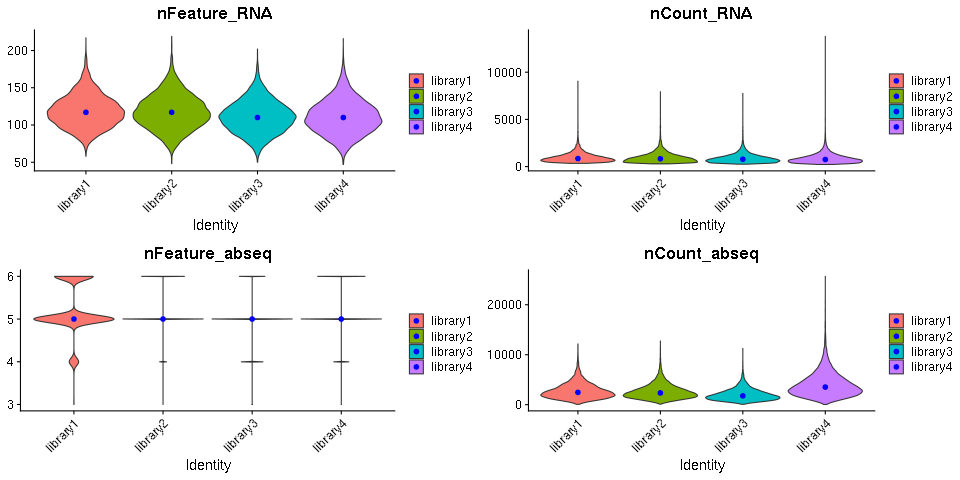

In [7]:
%%R -w 960 -h 480 -u px

n.features.violin <- VlnPlot(alldata.filtered, features = "nFeature_RNA", pt.size = 0, ncol = 2) + stat_summary(fun.y = median, geom='point', size = 2, colour = "blue")
n.counts.violin <- VlnPlot(alldata.filtered, features = "nCount_RNA", pt.size = 0, ncol = 2) + stat_summary(fun.y = median, geom='point', size = 2, colour = "blue")

n.features.ab.violin <- VlnPlot(alldata.filtered, features = "nFeature_abseq", pt.size = 0, ncol = 2) + stat_summary(fun.y = median, geom='point', size = 2, colour = "blue")
n.counts.ab.violin <- VlnPlot(alldata.filtered, features = "nCount_abseq", pt.size = 0, ncol = 2) + stat_summary(fun.y = median, geom='point', size = 2, colour = "blue")

grid.arrange(n.features.violin, n.counts.violin, n.features.ab.violin, n.counts.ab.violin, nrow = 2)

# Normalization, clustering

Set parameters for normalization, clustering:

In [8]:
%%R

remove.patient.five = TRUE # FALSE if you want to keep patient 5
cart.cells.only = TRUE     # TRUE if you only want CAR T cells
remove.multiplets = TRUE   # FALSE to keep multiplets
cluster.resolution = 0.6   
remove.ighgs = TRUE
ncomponents = 20

Load patient metadata:

In [9]:
%%R

# add patient metadata to the set, translate Swedish to English
patient.metadata <- read.table(file="../data/patient_metadata_1month.tsv", sep="\t", header = TRUE)
patient.metadata[patient.metadata["sex"] == "K",]["sex"] <- "F"
patient.metadata[patient.metadata["Gemcitabine"] == "J",]["Gemcitabine"] <- "Y"
patient.metadata[patient.metadata["Status_20_9_2021"] == "Lever",]["Status_20_9_2021"] <- "alive"
patient.metadata[patient.metadata["Status_20_9_2021"] == "lever",]["Status_20_9_2021"] <- "alive"
patient.metadata[patient.metadata["Status_20_9_2021"] == "Avliden",]["Status_20_9_2021"] <- "deceased"
patient.metadata[patient.metadata["Status_20_9_2021"] == "avliden",]["Status_20_9_2021"] <- "deceased"
colnames(patient.metadata)[9] <- "response_1month_2category"
colnames(patient.metadata)[10] <- "response_1month"

alldata.filtered@meta.data$sex <- NA
alldata.filtered@meta.data$CRS_grade <- NA
alldata.filtered@meta.data$CNS_tox_grade <- NA
alldata.filtered@meta.data$response_1month_2category <- NA
alldata.filtered@meta.data$response_1month <- NA
alldata.filtered@meta.data$status <- NA

for(i in seq(dim(alldata.filtered@meta.data)[1])){
    if(alldata.filtered@meta.data[i,]$Sample_Name != "Multiplet"){

        alldata.filtered@meta.data[i,]$sex <- patient.metadata[patient.metadata$Sample_Name == alldata.filtered@meta.data[i,]$Sample_Name,]$sex
        alldata.filtered@meta.data[i,]$CRS_grade <- patient.metadata[patient.metadata$Sample_Name == alldata.filtered@meta.data[i,]$Sample_Name,]$CRS_grade
        alldata.filtered@meta.data[i,]$CNS_tox_grade <- patient.metadata[patient.metadata$Sample_Name == alldata.filtered@meta.data[i,]$Sample_Name,]$CNS_tox_grade
        alldata.filtered@meta.data[i,]$response_1month_2category <- patient.metadata[patient.metadata$Sample_Name == alldata.filtered@meta.data[i,]$Sample_Name,]$response_1month_2category
        alldata.filtered@meta.data[i,]$response_1month <- patient.metadata[patient.metadata$Sample_Name == alldata.filtered@meta.data[i,]$Sample_Name,]$response_1month
        alldata.filtered@meta.data[i,]$status <- patient.metadata[patient.metadata$Sample_Name == alldata.filtered@meta.data[i,]$Sample_Name,]$Status_20_9_2021
    }
}

alldata.filtered@meta.data$response_1month <- factor(alldata.filtered@meta.data$response_1month, levels = c("CR", "PR", "SD", "PD"))
alldata.filtered@meta.data$response_1month_2category <- factor(alldata.filtered@meta.data$response_1month_2category)
alldata.filtered@meta.data$CRS_grade <- factor(alldata.filtered@meta.data$CRS_grade, levels = c("0", "1", "2", "3"))
alldata.filtered@meta.data$CNS_tox_grade <- factor(alldata.filtered@meta.data$CNS_tox_grade)


Filter out Multiplets, exclude one patient, remove IGHG-secreted counts:

In [10]:
%%R

counts <- GetAssayData(alldata.filtered, assay = "RNA")
counts.abseq <- GetAssayData(alldata.filtered, assay = "abseq")

ighgs <- c(which(rownames(counts) == "IGHG1-secreted"), 
           which(rownames(counts) == "IGHG2-secreted"))

if(remove.ighgs){
    counts <- counts[-ighgs,]
    alldata.filtered <- subset(alldata.filtered, features = rownames(counts))
}
# put abseq data back in
alldata.filtered[["abseq"]] <- CreateAssayObject(counts = counts.abseq)

if(remove.patient.five){
    alldata.filtered <- subset(alldata.filtered, subset = Sample_Name != "Pat5")
}

if(remove.multiplets){
    alldata.filtered <- subset(alldata.filtered, subset = Sample_Name != "Multiplet")
}

Normalization, scaling and initial dimensionality reduction:

R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

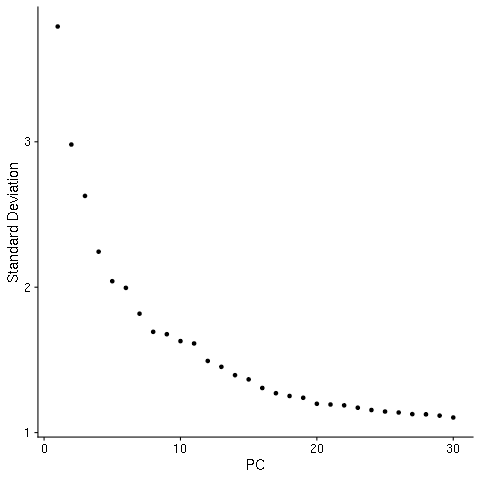

In [11]:
%%R
# normalization with default parameters
alldata.filtered <- NormalizeData(alldata.filtered)

# find variable features
alldata.filtered = FindVariableFeatures(alldata.filtered, verbose = F)

# scaling with regression
alldata.filtered = ScaleData(alldata.filtered, vars.to.regress = c("nFeature_RNA"), verbose = F)

# PCA
alldata.filtered = RunPCA(alldata.filtered, verbose = F, npcs = 30)

ElbowPlot(alldata.filtered, ndims = 30)


UMAP projection from selected PCA components:

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session



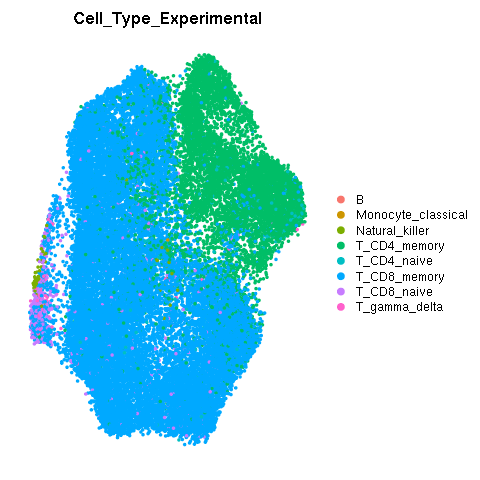

In [12]:
%%R -w 480 -h 480 -u px

# UMAP set to most useful components
alldata.filtered = RunUMAP(alldata.filtered, dims = 1:ncomponents, verbose = F)

DimPlot(alldata.filtered, group.by = "Cell_Type_Experimental", pt.size = 1, reduction = "umap") + NoAxes()

Cell cycle score calculation on a subset of available genes:

[1] "S cycle genes in panel:  PCNA, TYMS, MCM4"
[1] "G2M cycle genes in panel:  HMGB2, UBE2C, TOP2A, MKI67, AURKB, HMMR"


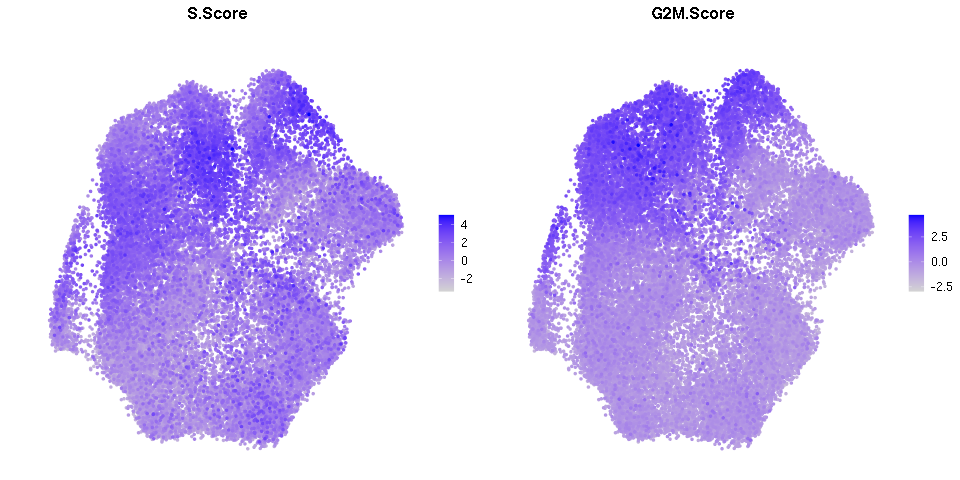

In [13]:
%%R -w 960 -h 480 -u px

s.genes <- intersect(cc.genes.updated.2019$s.genes,rownames(alldata.filtered))
g2m.genes <- intersect(cc.genes.updated.2019$g2m.genes,rownames(alldata.filtered))

print(paste("S cycle genes in panel: ", paste(s.genes, collapse=', ')))
print(paste("G2M cycle genes in panel: ", paste(g2m.genes, collapse=', ')))

alldata.filtered <- CellCycleScoring(
  object = alldata.filtered,
  g2m.features = g2m.genes,
  s.features = s.genes
)

S.plot <- FeaturePlot(object = alldata.filtered, features = "S.Score", pt.size = 1, order = TRUE) + NoAxes()
G2M.plot <- FeaturePlot(object = alldata.filtered, features = "G2M.Score", pt.size = 1, order = TRUE) + NoAxes()

grid.arrange(S.plot, G2M.plot, nrow=1)

Clustering:

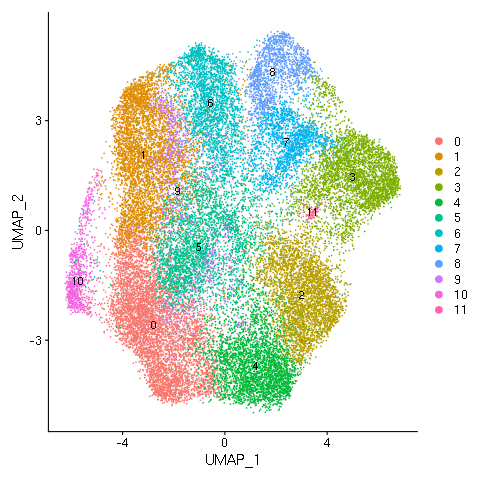

In [14]:
%%R -w 480 -h 480 -u px

alldata.filtered <- FindNeighbors(alldata.filtered, dims = 1:ncomponents, verbose = FALSE)
alldata.filtered <- FindClusters(alldata.filtered, verbose = FALSE, resolution = cluster.resolution)
Idents(alldata.filtered) <- "seurat_clusters"
DimPlot(alldata.filtered, label = TRUE)

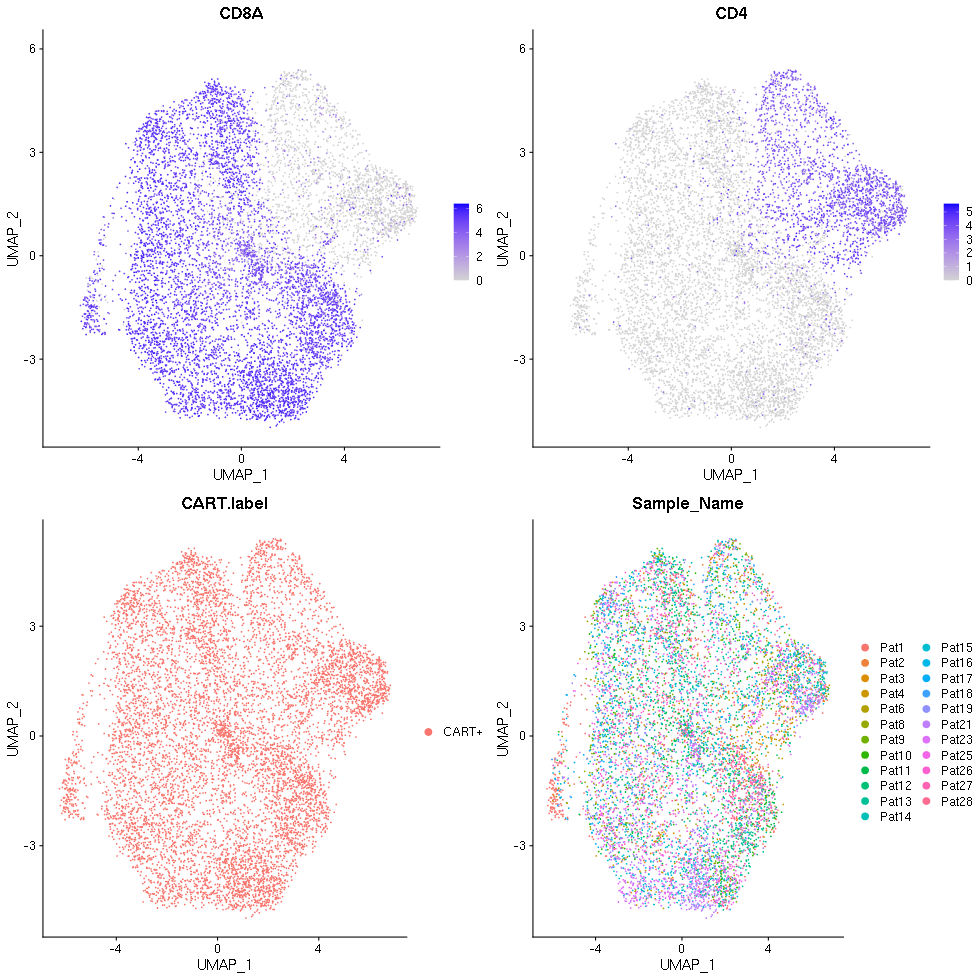

In [109]:
%%R -w 980 -h 980 -u px

cd8_plot <- FeaturePlot(alldata.filtered, features="CD8A")
cd4_plot <- FeaturePlot(alldata.filtered, features="CD4")
cart_plot <- DimPlot(alldata.filtered, group.by="CART.label")
pat_plot <- DimPlot(alldata.filtered, group.by="Sample_Name")

grid.arrange(cd8_plot, cd4_plot, cart_plot, pat_plot, nrow=2)

AbSeq plots:

R[write to console]: Warning:
R[write to console]:  Could not find CD4.SK3.CD4.AHS0032.pAbO in the default search locations, found in abseq assay instead

R[write to console]: Warning:
R[write to console]:  Could not find CD8.RPA.T8.CD8A.AHS0027.pAbO in the default search locations, found in abseq assay instead

R[write to console]: Warning:
R[write to console]:  Could not find CD45RA.HI100.PTPRC.AHS0009.pAbO in the default search locations, found in abseq assay instead

R[write to console]: Warning:
R[write to console]:  Could not find CCR7.CCR7.AHS0273.pAbO in the default search locations, found in abseq assay instead



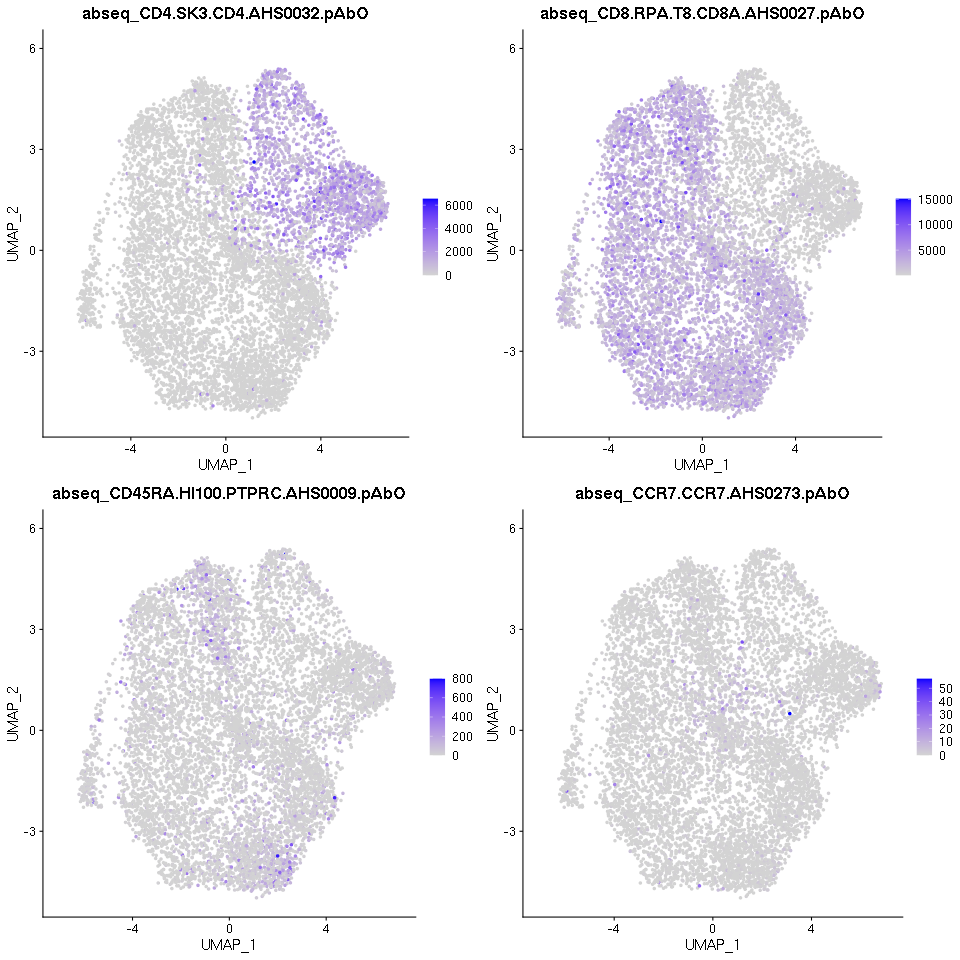

In [137]:
%%R -w 960 -h 960 -u px

a <- FeaturePlot(alldata.filtered, features="CD4.SK3.CD4.AHS0032.pAbO", pt.size=1)
b <- FeaturePlot(alldata.filtered, features="CD8.RPA.T8.CD8A.AHS0027.pAbO", pt.size=1)
c <- FeaturePlot(alldata.filtered, features="CD45RA.HI100.PTPRC.AHS0009.pAbO", pt.size=1)
d <- FeaturePlot(alldata.filtered, features="CCR7.CCR7.AHS0273.pAbO", pt.size=1)

grid.arrange(a, b, c, d, nrow = 2)

Select CART+ only cells, separate CD4 and CD8 cells:

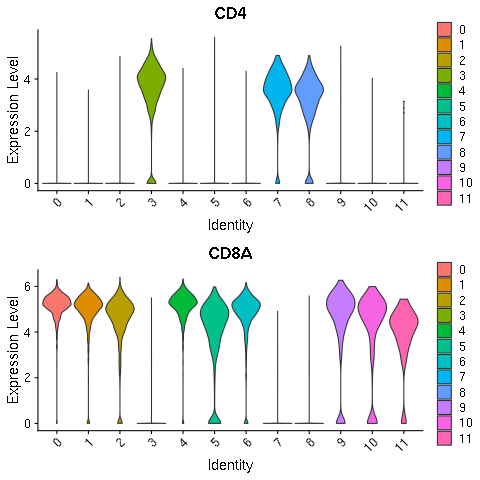

In [19]:
%%R -w 480 -h 480 -u px

alldata.filtered <- subset(x = alldata.filtered, subset = CART.label == "CART+")

cd4.by.cluster <- VlnPlot(alldata.filtered, features = "CD4", pt.size = 0.)
cd8.by.cluster <- VlnPlot(alldata.filtered, features = "CD8A", pt.size = 0.)

grid.arrange(cd4.by.cluster, cd8.by.cluster, nrow =2)

avg.cd4 <- lapply(AverageExpression(alldata.filtered, features = "CD4",group.by = "ident", slot = "data", assays = "RNA"), log)$RNA
cd4.clusters <- which(avg.cd4 > 3) - 1

cd8.clusters <- setdiff(levels(alldata.filtered$seurat_clusters), cd4.clusters)

data.cd4 <- subset(x = alldata.filtered, idents = cd4.clusters)
data.cd8 <- subset(x = alldata.filtered, idents = cd8.clusters)

# CD8 cell analysis, DGE

In [20]:
%%R

markers.cd8 <- FindAllMarkers(object = data.cd8, test.use="wilcox")

R[write to console]: Calculating cluster 0



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 16% ~02s           |+++++++++                                         | 18% ~02s 

R[write to console]: Calculating cluster 1



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~03s           |++                                                | 3 % ~02s           |+++                                               | 5 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 12% ~02s           |+++++++                                           | 13% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s 

R[write to console]: Calculating cluster 2



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 11% ~02s           |++++++                                            | 12% ~02s           |+++++++                                           | 13% ~02s           |+++++++                                           | 14% ~02s 

R[write to console]: Calculating cluster 4



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 2 % ~02s           |++                                                | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 9 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s           |++++++++                                          | 16% ~02s 

R[write to console]: Calculating cluster 5



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 4 % ~03s           |+++                                               | 5 % ~03s           |++++                                              | 6 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~03s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 13% ~02s 

R[write to console]: Calculating cluster 6



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |+++++                                             | 8 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 14% ~02s           |++++++++                                          | 15% ~02s           |+++++++++                                         | 16% ~02s           |+++++++++                                         | 18% ~02s 

R[write to console]: Calculating cluster 9



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~03s           |++                                                | 3 % ~03s           |+++                                               | 4 % ~03s           |+++                                               | 6 % ~03s           |++++                                              | 7 % ~03s           |++++                                              | 8 % ~03s           |+++++                                             | 9 % ~03s           |+++++                                             | 10% ~03s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 14% ~02s 

R[write to console]: Calculating cluster 10



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~03s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 6 % ~02s           |++++                                              | 7 % ~03s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |++++++                                            | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s 

R[write to console]: Calculating cluster 11



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03s           |++                                                | 2 % ~02s           |++                                                | 3 % ~02s           |+++                                               | 4 % ~02s           |+++                                               | 5 % ~02s           |++++                                              | 7 % ~02s           |++++                                              | 8 % ~02s           |+++++                                             | 9 % ~02s           |+++++                                             | 10% ~02s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 14% ~02s 

In [21]:
%%R 

selected.markers <- markers.cd8 %>% group_by(cluster) %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 1.25)
print(selected.markers, n=104)

# A tibble: 104 x 7
# Groups:   cluster [9]
        p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene       
        <dbl>      <dbl> <dbl> <dbl>     <dbl> <fct>   <chr>      
  1 2.03e-154       1.54 0.707 0.321 9.27e-152 0       GZMK       
  2 1.47e-151       1.52 0.626 0.253 6.70e-149 0       GZMH       
  3 3.29e-140       1.34 0.711 0.365 1.50e-137 0       CCR5       
  4 1.51e-244       1.51 0.992 0.8   6.89e-242 1       HMGB2      
  5 1.45e-214       1.51 0.746 0.24  6.59e-212 1       UBE2C      
  6 3.91e-197       1.45 0.865 0.398 1.78e-194 1       KIAA0101   
  7 4.04e-197       1.53 0.784 0.295 1.84e-194 1       TK1        
  8 1.36e-189       1.26 0.937 0.518 6.19e-187 1       TYMS       
  9 1.45e-185       1.55 0.708 0.247 6.59e-183 1       AURKB      
 10 4.51e-129       1.33 0.77  0.411 2.06e-126 1       PTTG2      
 11 3.39e-113       1.48 0.499 0.174 1.55e-110 1       CCNB1      
 12 0               3.63 0.635 0.069 0         2       PTGDR2     
 13 7.20e-279     

 69 2.29e-195       3.07 0.443 0.026 1.04e-192 10      KIR2DL1    
 70 1.45e-150       3.28 0.734 0.118 6.59e-148 10      FCGR3A     
 71 3.91e-130       2.89 0.714 0.125 1.78e-127 10      KLRC1      
 72 1.67e-104       2.34 0.391 0.042 7.60e-102 10      IKZF2      
 73 4.96e- 77       2.19 0.589 0.134 2.26e- 74 10      KLRG1      
 74 5.42e- 76       1.49 1     0.956 2.47e- 73 10      NKG7       
 75 1.12e- 64       3.40 0.182 0.014 5.11e- 62 10      TRDC       
 76 5.60e- 64       1.84 0.969 0.544 2.55e- 61 10      TARP-refseq
 77 9.64e- 59       2.02 0.786 0.302 4.40e- 56 10      GZMH       
 78 6.53e- 58       1.93 0.604 0.178 2.98e- 55 10      PIK3AP1    
 79 8.46e- 52       1.27 0.99  0.874 3.86e- 49 10      CTSW       
 80 3.57e- 38       1.74 0.344 0.084 1.63e- 35 10      LYN        
 81 1.02e- 36       1.94 0.203 0.031 4.65e- 34 10      CX3CR1     
 82 6.84e- 36       1.48 0.656 0.297 3.12e- 33 10      LAT2       
 83 3.82e- 34       1.42 0.75  0.375 1.74e- 31 10      GZMK   

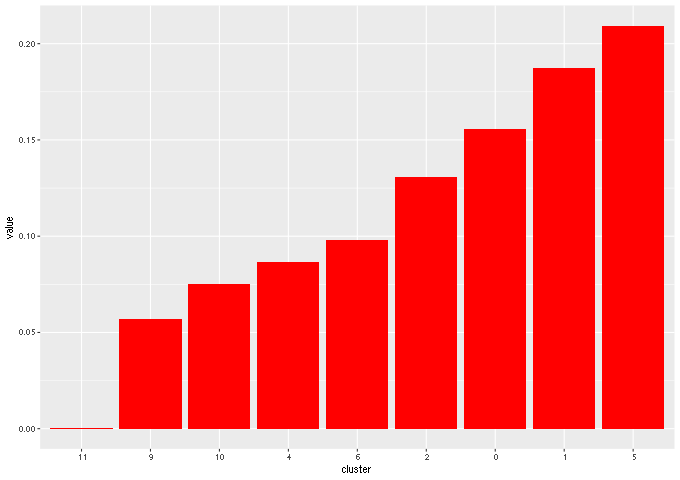

In [22]:
%%R -w 680 -h 480 -u px

response_by_cluster <- table(Idents(data.cd8), data.cd8$response_1month_2category)
response_by_cluster_perc <- t(t(response_by_cluster)/colSums(response_by_cluster))
response_by_cluster_perc <- melt(response_by_cluster_perc)
colnames(response_by_cluster_perc) <- c("cluster", "response", "value")
response_by_cluster_perc$cluster <- factor(response_by_cluster_perc$cluster, levels=c(11, 9, 10, 4, 6, 2, 0, 1, 5))
ggplot(response_by_cluster_perc[response_by_cluster_perc$response=="R",], aes(fill=response, y=value, x=cluster)) + 
    geom_bar(position="dodge", stat="identity", fill="red")

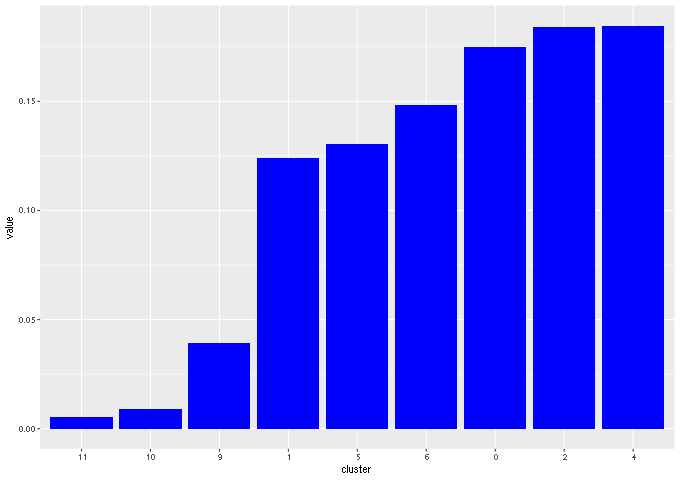

In [23]:
%%R -w 680 -h 480 -u px

response_by_cluster_perc$cluster <- factor(response_by_cluster_perc$cluster, levels=c(11, 10, 9, 1, 5, 6, 0, 2, 4))
ggplot(response_by_cluster_perc[response_by_cluster_perc$response=="NR",], aes(fill=response, y=value, x=cluster)) + 
    geom_bar(position="dodge", stat="identity", fill="blue")

DGE according to 2-category response label:

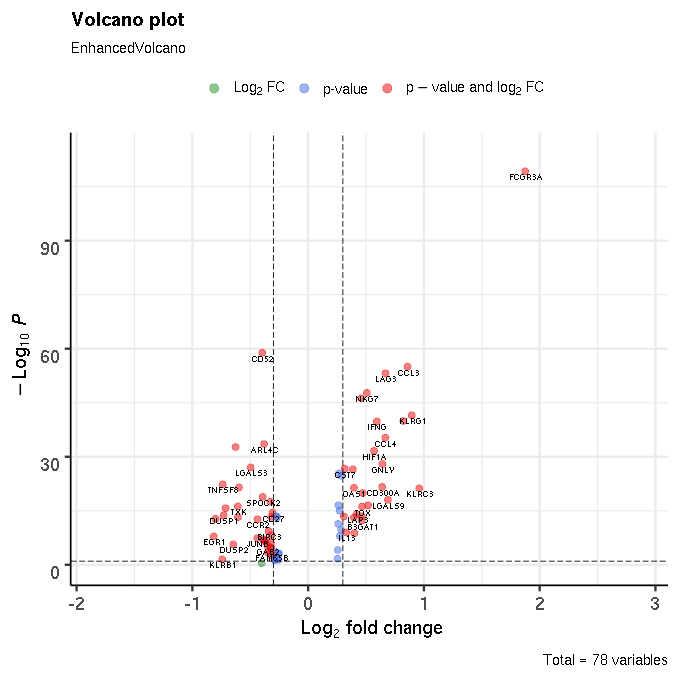

In [24]:
%%R -w 680 -h 680 -u px

markers.cd8 <- FindMarkers(object = data.cd8, 
                                        ident.1 = "R", 
                                        ident.2 = "NR", 
                                        group.by = "response_1month_2category",
                                        verbose=FALSE)

EnhancedVolcano(markers.cd8,
    lab = rownames(markers.cd8),
    x = 'avg_log2FC',
    y = 'p_val',
    pCutoff = 10e-2,
    FCcutoff = 0.3,
    pointSize = 3.0,)

# CD4 cell analysis, DGE

In [25]:
%%R

markers.cd4 <- FindAllMarkers(object = data.cd4)
markers.cd4 %>% group_by(cluster) %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 1.25)

R[write to console]: Calculating cluster 3



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |++++++                                            | 10% ~01s           |++++++                                            | 11% ~02s           |+++++++                                           | 12% ~02s           |+++++++                                           | 13% ~02s           |++++++++                                          | 15% ~02s 

R[write to console]: Calculating cluster 7



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 2 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 5 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 12% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s 

R[write to console]: Calculating cluster 8



  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |++                                                | 3 % ~01s           |+++                                               | 4 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |+++++++                                           | 13% ~01s           |++++++++                                          | 14% ~01s           |++++++++                                          | 16% ~01s           |+++++++++                                         | 17% ~01s           |++++++++++                                        | 19% ~01s 

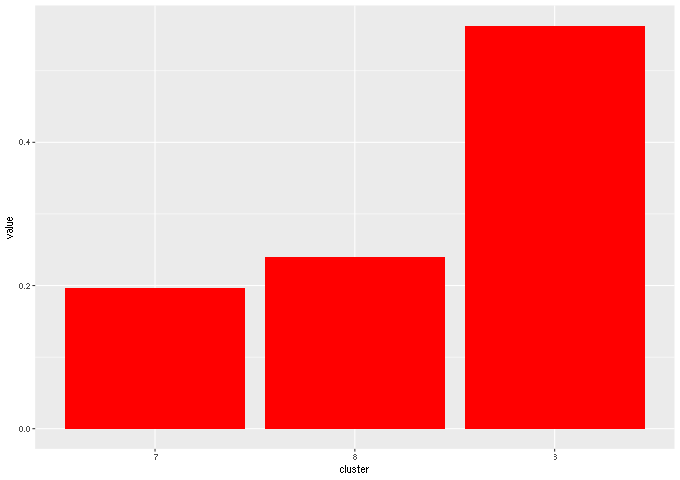

In [26]:
%%R -w 680 -h 480 -u px

response_by_cluster <- table(Idents(data.cd4), data.cd4$response_1month_2category)
response_by_cluster_perc <- t(t(response_by_cluster)/colSums(response_by_cluster))
response_by_cluster_perc <- melt(response_by_cluster_perc)
colnames(response_by_cluster_perc) <- c("cluster", "response", "value")
response_by_cluster_perc$cluster <- factor(response_by_cluster_perc$cluster, levels=c(7,8,3))
ggplot(response_by_cluster_perc[response_by_cluster_perc$response=="R",], aes(fill=response, y=value, x=cluster)) + 
    geom_bar(position="dodge", stat="identity", fill="red")

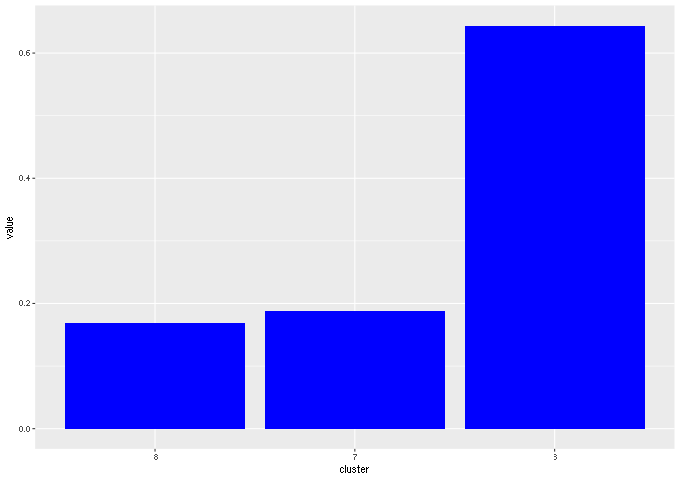

In [27]:
%%R -w 680 -h 480 -u px

response_by_cluster_perc$cluster <- factor(response_by_cluster_perc$cluster, levels=c(8, 7, 3))
ggplot(response_by_cluster_perc[response_by_cluster_perc$response=="NR",], aes(fill=response, y=value, x=cluster)) + 
    geom_bar(position="dodge", stat="identity", fill="blue")

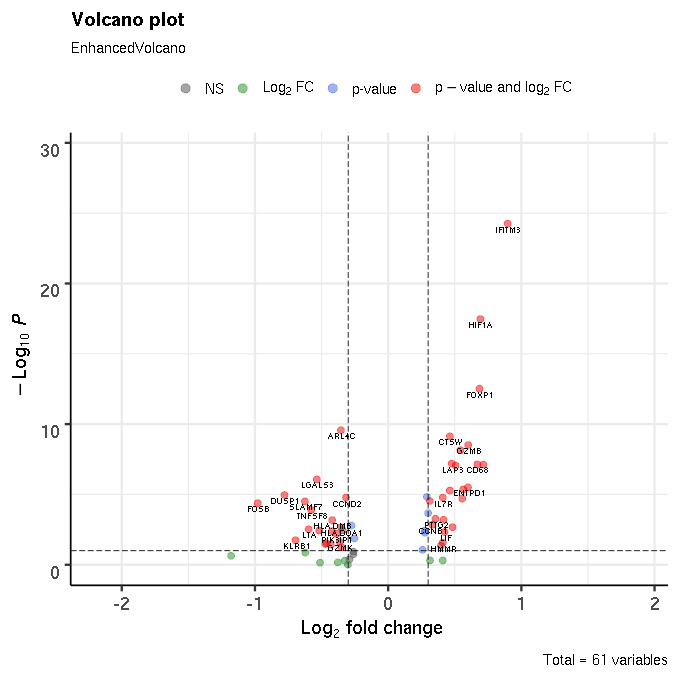

In [28]:
%%R -w 680 -h 680 -u px

markers.cd4 <- FindMarkers(object = data.cd4, 
                                        ident.1 = "R", 
                                        ident.2 = "NR", 
                                        group.by = "response_1month_2category",
                                        verbose=FALSE)


EnhancedVolcano(markers.cd4,
    lab = rownames(markers.cd4),
    x = 'avg_log2FC',
    y = 'p_val',
    pCutoff = 10e-2,
    FCcutoff = 0.3,
    pointSize = 3.0,)

# Polyfunctional score analysis, CD8

In [29]:
%%R
expansion_days <- read_excel("../data/expansion_days.xlsx")
colnames(expansion_days) <- c("Sample_Name", "expansion_days")

# we decided that normalizing did not really help
# with respect to patient biases
counts.cd8 <- GetAssayData(data.cd8, assay = "RNA", slot = "counts")

data.cd8@meta.data$response_1month <- factor(data.cd8@meta.data$response_1month, 
                            levels=c("PD","SD", "PR", "CR"))

pat_levels=c("Pat2", "Pat14", "Pat16", "Pat17", "Pat18", "Pat23", "Pat25", "Pat26", "Pat27", #PD
                                    "Pat3", "Pat6", "Pat12", "Pat13", "Pat15", "Pat21", #SD
                                     "Pat1", "Pat4", "Pat28",  #PR
                                       "Pat8", "Pat9", "Pat10", "Pat11", "Pat19"  #CR     
                                     )

resp_levels=c("PD", "SD", "PR", "CR")
resp_levels_2category=c("NR", "R")

data.cd8@meta.data$expansion_days <- merge(data.cd8@meta.data, expansion_days)$expansion_days
data.cd8@meta.data$Sample_Name <- factor(data.cd8@meta.data$Sample_Name, levels=pat_levels)

sample_name_by_response <- unique(data.cd8@meta.data[c("Sample_Name", "response_1month", "response_1month_2category")])

R[write to console]: 
R[write to console]: -
R[write to console]: 
R[write to console]: /
                                                                              
R[write to console]: 
R[write to console]: New names:
* `` -> ...1



## Polyfunctional classification

In [30]:
%%R
regulatory.genes <- c("IL4", "IL10", "IL13", "IL22", "TGFB1") #, "TNFRSF9", "CD40LG"
regulatory.genes <- intersect(regulatory.genes, rownames(counts.cd8))
effector.genes <- c("GZMB", "IFNG", "CCL3", "MIP1A", "PRF1", "TNF", "TNFA", "TNFB")
effector.genes <- intersect(effector.genes, rownames(counts.cd8))
stimulatory.genes <- c("CSF2", "IL2", "IL5", "IL7", "IL8", "IL9", "IL12", "IL15", "IL21")
stimulatory.genes <- intersect(stimulatory.genes, rownames(counts.cd8))
chemoattractive.genes <- c("CCL11", "CXCL10", "CCL4", "CCL5")
chemoattractive.genes <- intersect(chemoattractive.genes, rownames(counts.cd8))
inflammatory.genes <- c("IL1B", "IL6", "IL17F") # "IL17A", "CCL2", "CCL13"
inflammatory.genes <- intersect(inflammatory.genes, rownames(counts.cd8))

inhibitory.genes <- c("CD244", "PDCD1", "CTLA4", "GP49B", "PTGER4", "CD160", "LAG3", "PTGER2", "HAVCR2")
inhibitory.genes <- intersect(inhibitory.genes, rownames(counts.cd8))

all.genes <- c(regulatory.genes, effector.genes, stimulatory.genes, chemoattractive.genes, inflammatory.genes, inhibitory.genes)

# how do we calculate the background intensity?
# median of non-zero counts
background_calc <- function(gene){
    med <- median(counts.cd8[gene, counts.cd8[gene,]>0])
    mad <- median(abs(counts.cd8[gene, counts.cd8[gene,]>0] - med))
    if(is.na(med)){
        med <- 0
    }
    return(med)
}

background <- function(genelist) (sapply(genelist, background_calc))

data.cd8@meta.data$n.regulatory.genes <- colSums(counts.cd8[regulatory.genes,] > background(regulatory.genes))
data.cd8@meta.data$n.effector.genes <- colSums(counts.cd8[effector.genes,] > background(effector.genes))
data.cd8@meta.data$n.stimulatory.genes <- colSums(counts.cd8[stimulatory.genes,] > background(stimulatory.genes))
data.cd8@meta.data$n.chemoattractive.genes <- colSums(counts.cd8[chemoattractive.genes,] > background(chemoattractive.genes))
data.cd8@meta.data$n.inflammatory.genes <- colSums(counts.cd8[inflammatory.genes,] > background(inflammatory.genes))
data.cd8@meta.data$n.inhibitory.genes <- colSums(counts.cd8[inhibitory.genes,] > background(inhibitory.genes))

data.cd8@meta.data$c.regulatory.genes <- colSums(counts.cd8[regulatory.genes,])
data.cd8@meta.data$c.effector.genes <- colSums(counts.cd8[effector.genes,])
data.cd8@meta.data$c.stimulatory.genes <- colSums(counts.cd8[stimulatory.genes,])
data.cd8@meta.data$c.chemoattractive.genes <- colSums(counts.cd8[chemoattractive.genes,])
data.cd8@meta.data$c.inflammatory.genes <- colSums(counts.cd8[inflammatory.genes,])
data.cd8@meta.data$c.inhibitory.genes <- colSums(counts.cd8[inhibitory.genes,])

polyf.classes <- c("n.regulatory.genes", "n.effector.genes", "n.stimulatory.genes",
                   "n.chemoattractive.genes", "n.inflammatory.genes", "n.inhibitory.genes")

thr <- 1 # number of genes needed to consider that cell having that function
data.cd8@meta.data$polyfunctionality <- rowSums(data.cd8@meta.data[polyf.classes] >= thr)

In [31]:
%%R -w 960 -h 480 -u px

#create data frame with 0 rows and 5 columns
polyf_table_patient <- "NA"
c <- 0

for(patient in pat_levels){

    this_patient <- data.cd8@meta.data %>% filter(Sample_Name == patient)
    n_cells_this_patient <- nrow(this_patient)
    polyf_profile_this_patient <- (this_patient %>% count(polyfunctionality))
    
    polyf_profile_this_patient$n <- polyf_profile_this_patient$n / n_cells_this_patient
    if(c == 0){
        polyf_table_patient <- polyf_profile_this_patient
        c = c+1
    }else{        
        polyf_table_patient <- merge(polyf_table_patient, polyf_profile_this_patient, by="polyfunctionality", all.x=TRUE, all.y=TRUE)        
    }
}

rownames(polyf_table_patient) <- polyf_table_patient[,1]
polyf_table_patient <- polyf_table_patient[,-1]
polyf_table_patient[is.na(polyf_table_patient)] <- 0
colnames(polyf_table_patient) <- levels(data.cd8$Sample_Name)


labelcol = c("red", "red", "red", "red", "red", "red","red", "red", "red",
            "orange", "orange", "orange", "orange", "orange", "orange",
             "blue", "blue", "blue",
            "green", "green", "green", "green", "green")

polyf_table_patient_long <- polyf_table_patient[,pat_levels]
polyf_table_patient_long$polyfunctionality <- as.factor(0:(nrow(polyf_table_patient_long)-1))
polyf_table_patient_long <- melt(polyf_table_patient_long, id.vars = "polyfunctionality")
colnames(polyf_table_patient_long) <- c("polyfunctionality", "Patient", "polyf_frac")

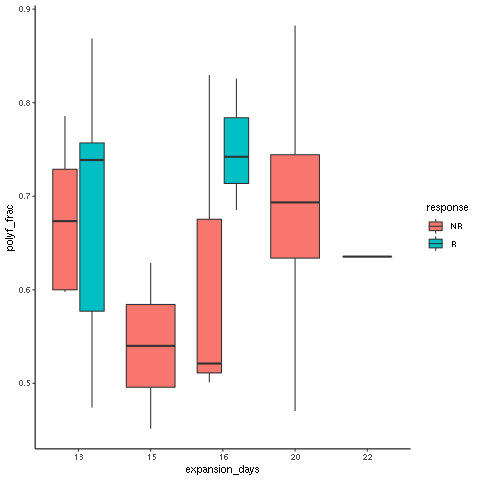

In [32]:
%%R
pf_2_to_5 <- polyf_table_patient_long[polyf_table_patient_long$polyfunctionality != 0 & polyf_table_patient_long$polyfunctionality != 1,]
pf_2_to_5 <- aggregate(pf_2_to_5$polyf_frac, by=list(pf_2_to_5$Patient), FUN=sum)
colnames(pf_2_to_5) <- c("Sample_Name", "polyf_frac")

pf_2_to_5 <- merge(pf_2_to_5, expansion_days)
pf_2_to_5 <- merge(pf_2_to_5, unique(data.cd8@meta.data[c("Sample_Name", "response_1month_2category")]), by="Sample_Name")
colnames(pf_2_to_5) <- c("Sample_Name", "polyf_frac", "expansion_days", "response")

pf_2_to_5$expansion_days <- factor(pf_2_to_5$expansion_days)
ggplot(pf_2_to_5, aes(x=expansion_days, y=polyf_frac, fill=response)) + 
    geom_boxplot() +
    theme_classic()

In [33]:
%%R
total_polyf_patient <- polyf_table_patient_long[polyf_table_patient_long$polyfunctionality != 0 & polyf_table_patient_long$polyfunctionality != 1,]

total_polyf_patient <- aggregate(total_polyf_patient$polyf_frac, by=list(total_polyf_patient$Patient), FUN=sum)
colnames(total_polyf_patient) <- c("Sample_Name", "polyf_frac")
total_polyf_patient_response <- merge(total_polyf_patient, sample_name_by_response)
polyf_mean_by_response <- aggregate(total_polyf_patient_response$polyf_frac, by=list(total_polyf_patient_response$response_1month), FUN=mean)


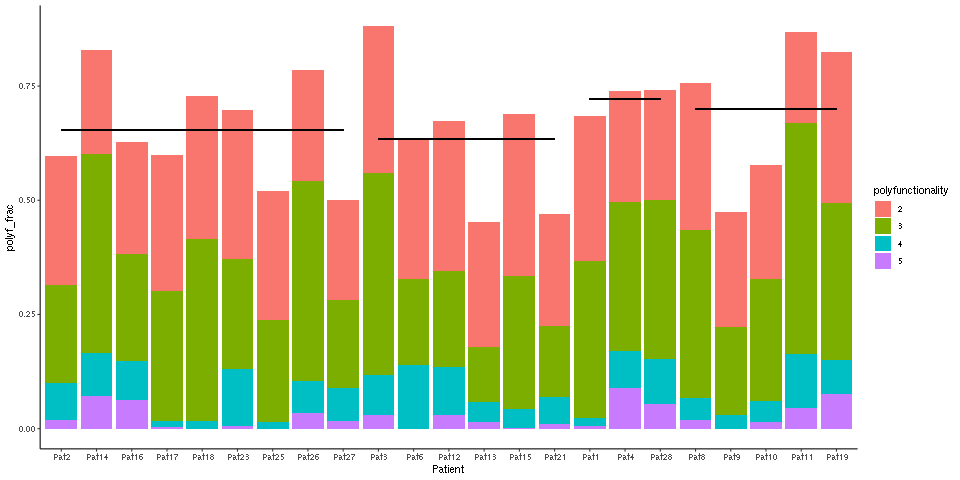

In [34]:
%%R -w 960 -h 480 -u px

ggplot(polyf_table_patient_long[polyf_table_patient_long$polyfunctionality != 0 & polyf_table_patient_long$polyfunctionality != 1,],
       aes(x = Patient,
           y = polyf_frac,
           fill = polyfunctionality)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, colour = labelcol)) +
    geom_segment(aes(x = 1, y = polyf_mean_by_response$x[1], xend = 9, yend = polyf_mean_by_response$x[1])) +
    geom_segment(aes(x = 10, y = polyf_mean_by_response$x[2], xend = 15, yend = polyf_mean_by_response$x[2])) +
    geom_segment(aes(x = 16, y = polyf_mean_by_response$x[3], xend = 18, yend = polyf_mean_by_response$x[3])) +
    geom_segment(aes(x = 19, y = polyf_mean_by_response$x[4], xend = 23, yend = polyf_mean_by_response$x[4])) + 
    theme_classic()


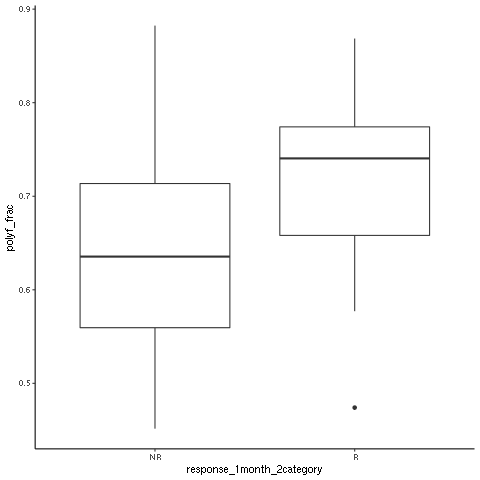

In [35]:
%%R

ggplot(total_polyf_patient_response, aes(x=response_1month_2category, y=polyf_frac)) + 
    geom_boxplot() + 
    theme_classic()

## scPSI scoring

In [36]:
%%R
c <- 0

# Calculate PIF similarly to original reference
for(patient in pat_levels){
    
    cells_this_patient <- data.cd8@meta.data %>% filter(Sample_Name == patient)
    
    polyf_cells_this_patient <- cells_this_patient %>% filter(polyfunctionality > 1)
    n_cells_this_patient <- dim(cells_this_patient)[1]
    n_polyf_cells_this_patient <- dim(polyf_cells_this_patient)[1]

    #counts_this_patient <- sum(counts.cd8[, rownames(cells_this_patient)])

    reg_counts_this_patient <- sum(counts.cd8[regulatory.genes, rownames(polyf_cells_this_patient)])
    reg_strength_this_patient <- reg_counts_this_patient/(length(regulatory.genes)*n_cells_this_patient)
    
    eff_counts_this_patient <- sum(counts.cd8[effector.genes, rownames(polyf_cells_this_patient)])
    eff_strength_this_patient <- eff_counts_this_patient/(length(effector.genes)*n_cells_this_patient)
    
    stim_counts_this_patient <- sum(counts.cd8[stimulatory.genes, rownames(polyf_cells_this_patient)])
    stim_strength_this_patient <- stim_counts_this_patient/(length(stimulatory.genes)*n_cells_this_patient)
    
    chem_counts_this_patient <- sum(counts.cd8[chemoattractive.genes, rownames(polyf_cells_this_patient)])
    chem_strength_this_patient <- chem_counts_this_patient/(length(chemoattractive.genes)*n_cells_this_patient)
    
    infl_counts_this_patient <- sum(counts.cd8[inflammatory.genes, rownames(polyf_cells_this_patient)])
    infl_strength_this_patient <- infl_counts_this_patient/(length(inflammatory.genes) * n_cells_this_patient)
    
    inh_counts_this_patient <- sum(counts.cd8[inhibitory.genes, rownames(polyf_cells_this_patient)])
    inh_strength_this_patient <- inh_counts_this_patient/(length(inhibitory.genes)*n_cells_this_patient)

    psi_this_patient <- c(reg_strength_this_patient, eff_strength_this_patient, stim_strength_this_patient, 
                         chem_strength_this_patient, infl_strength_this_patient, inh_strength_this_patient)
    if(c == 0){
        psi_table_patient <- psi_this_patient
        c = c+1
    }else{        
        psi_table_patient <- rbind(psi_table_patient, psi_this_patient)
    }
}

rownames(psi_table_patient) <- pat_levels
colnames(psi_table_patient) <- c("Regulatory", "Effector", "Stimulatory", "Chemoattractive", "Inflammatory", "Inhibitory")
psi_table_patient_long <- melt(psi_table_patient)
colnames(psi_table_patient_long) <- c("Patient", "Class", "scPSI")

Boxplot of scPSI vs. expansion days, split by response type:

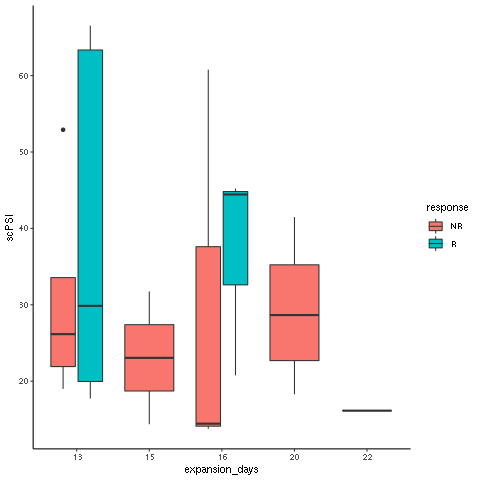

In [37]:
%%R
psi_aggregate <- aggregate(psi_table_patient_long$scPSI, by=list(psi_table_patient_long$Patient), FUN=sum)
colnames(psi_aggregate) <- c("Sample_Name", "scPSI")

psi_aggregate <- merge(psi_aggregate, expansion_days)
psi_aggregate <- merge(psi_aggregate, unique(data.cd8@meta.data[c("Sample_Name", "response_1month_2category")]), by="Sample_Name")
colnames(psi_aggregate) <- c("Sample_Name", "scPSI", "expansion_days", "response")

psi_aggregate$expansion_days <- factor(psi_aggregate$expansion_days)
ggplot(psi_aggregate, aes(x=expansion_days, y=scPSI, fill=response)) + 
    geom_boxplot() +
    theme_classic()


scPSI per patient:

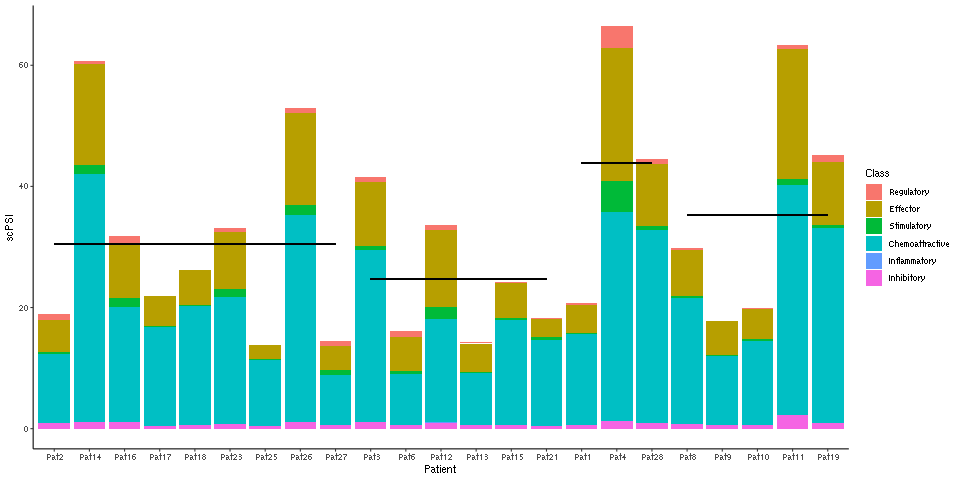

In [38]:
%%R -w 960 -h 480 -u px

total_psi_patient <- aggregate(psi_table_patient_long$scPSI, by=list(psi_table_patient_long$Patient), FUN=sum)
colnames(total_psi_patient) <- c("Sample_Name", "scPSI")
total_psi_patient_response <- merge(total_psi_patient, sample_name_by_response)
psi_mean_by_response <- aggregate(total_psi_patient_response$scPSI, by=list(total_psi_patient_response$response_1month), FUN=mean)
psi_sd_by_response <- aggregate(total_psi_patient_response$scPSI, by=list(total_psi_patient_response$response_1month), FUN=sd)

ggplot(psi_table_patient_long,
       aes(x = Patient,
           y = scPSI,
           fill = Class)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, colour = labelcol)) +
    geom_segment(aes(x = 1, y = psi_mean_by_response$x[1], xend = 9, yend = psi_mean_by_response$x[1])) +
    geom_segment(aes(x = 10, y = psi_mean_by_response$x[2], xend = 15, yend = psi_mean_by_response$x[2])) +
    geom_segment(aes(x = 16, y = psi_mean_by_response$x[3], xend = 18, yend = psi_mean_by_response$x[3])) +
    geom_segment(aes(x = 19, y = psi_mean_by_response$x[4], xend = 23, yend = psi_mean_by_response$x[4])) +
    theme_classic()


Here we perform bootstrapping by randomly subsetting many times (1000) all patients to 50 cells each (lowest amount of cells in patient 3 is 68). This allows to estimate mean and SD for both polyfunctionality and scPSI, then we plot these as barplots with error bars:

In [39]:

%%R

for(i in 1:1000){
    data.cd8.subset <- subset(data.cd8, downsample = 50, seed=NULL)
    c <- 0

    # Calculate PIF similarly to original reference
    for(response in resp_levels_2category){

        cells_this_response <- data.cd8.subset@meta.data %>% filter(response_1month_2category == response)
        polyf_cells_this_response <- cells_this_response %>% filter(polyfunctionality > 1)
        n_cells_this_response <- dim(cells_this_response)[1]
        n_polyf_cells_this_response <- dim(polyf_cells_this_response)[1]

        reg_counts_this_response <- sum(counts.cd8[regulatory.genes, rownames(polyf_cells_this_response)])
        reg_strength_this_response <- reg_counts_this_response/(length(regulatory.genes)*n_cells_this_response)

        eff_counts_this_response <- sum(counts.cd8[effector.genes, rownames(polyf_cells_this_response)])
        eff_strength_this_response <- eff_counts_this_response/(length(effector.genes)*n_cells_this_response)

        stim_counts_this_response <- sum(counts.cd8[stimulatory.genes, rownames(polyf_cells_this_response)])
        stim_strength_this_response <- stim_counts_this_response/(length(stimulatory.genes)*n_cells_this_response)

        chem_counts_this_response <- sum(counts.cd8[chemoattractive.genes, rownames(polyf_cells_this_response)])
        chem_strength_this_response <- chem_counts_this_response/(length(chemoattractive.genes)*n_cells_this_response)

        infl_counts_this_response <- sum(counts.cd8[inflammatory.genes, rownames(polyf_cells_this_response)])
        infl_strength_this_response <- infl_counts_this_response/(length(inflammatory.genes)*n_cells_this_response)

        inh_counts_this_response <- sum(counts.cd8[inhibitory.genes, rownames(polyf_cells_this_response)])
        inh_strength_this_response <- inh_counts_this_response/(length(inhibitory.genes)*n_cells_this_response)

        pif_this_response <- c(reg_strength_this_response, eff_strength_this_response, stim_strength_this_response, 
                             chem_strength_this_response, infl_strength_this_response, inh_strength_this_response)

        if(c == 0){
            pif_table <- pif_this_response
            c = c+1
        }else{        
            pif_table <- rbind(pif_table, pif_this_response)
        }
    }
    rownames(pif_table) <- resp_levels_2category
    colnames(pif_table) <- c("Regulatory", "Effector", "Stimulatory", "Chemoattractive", "Inflammatory", "Inhibitory")
    if(i == 1){
        pif_table_iter <- pif_table
    }else{
        pif_table_iter <- abind(pif_table_iter, pif_table, along=3)
    }
}

pif_sd <-apply(pif_table_iter,c(1,3), sum)
pif_sd <- apply(pif_sd, 1, sd)
pif_sum_mean <- apply(apply(pif_table_iter, c(1,2), mean), 1, sum)

pif_table_long <- apply(pif_table_iter,c(1,2), mean)
pif_table_long <- melt(pif_table_long)
colnames(pif_table_long) <- c("Response", "Class", "scPSI")

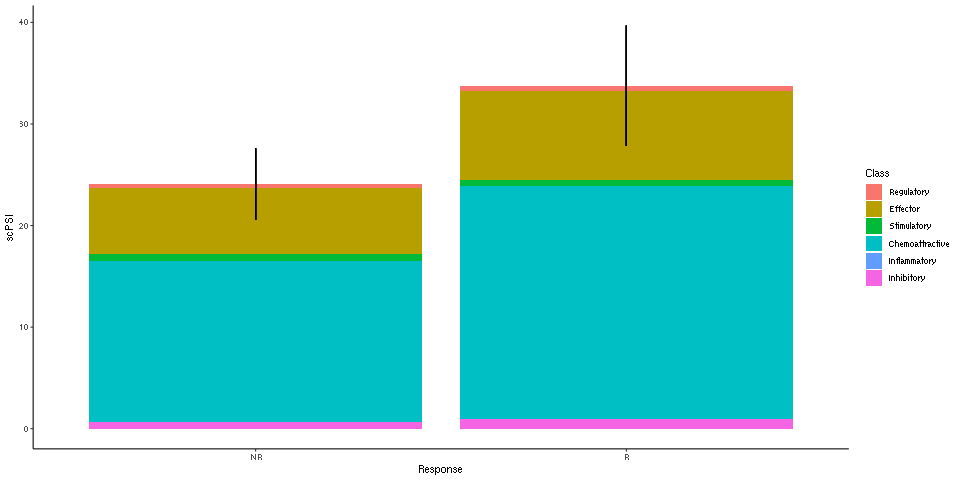

In [40]:
%%R -w 960 -h 480 -u px

responsecol_2category <- c("Red", "Green")

ggplot(pif_table_long,
       aes(x = Response,
           y = scPSI,
           fill = Class)) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(hjust = 1, colour = responsecol_2category)) + 
    geom_segment(aes(x = 1, y = pif_sum_mean[1] + pif_sd[1], xend = 1, yend = pif_sum_mean[1] - pif_sd[1])) + 
    geom_segment(aes(x = 2, y = pif_sum_mean[2] + pif_sd[2], xend = 2, yend = pif_sum_mean[2] - pif_sd[2])) +
    theme_classic()

# AUCell scoring

Define gene sets for each cell class, then run AUCell to score each cell in each class:

In [47]:
%%R

cell.ranking <- AUCell_buildRankings(exprMat = counts.cd8, nCores = 4, splitByBlocks=TRUE)

cytokine_genes <- c("CCL3", "CCL3L3", "CCL4L2", "IFNG", "CCL4", "GZMB", "XCL1", "XCL2", "CSF2", "CCR1", "IL10", "HOPX", "FASLG", "GZMH", "BATF3", "TIMD4", "FEZ1", "HAVCR2", "ZBTB32", "SLC27A2", "LAG3", "PRF1", "IL18RAP", "GZMA", "PTMS", "PHLDA1", "ZBED2", "NCS1", "IQCG", "JAKMIP1", "KLRC1", "CRTAM", "CCR5", "EGR2", "TNFRSF9", "TNF", "SLC4A10", "ADAM19", "MSC", "METRNL", "SLAMF7", "NKG7", "CXCR6", "CD70", "ATP8B4", "SDC4", "ELOVL6", "ADAP1", "IL26", "RDH10", "LTA", "MICAL2", "TNIP3", "CCL20", "ULBP2", "CEBPD", "RCAN2", "ZEB2", "CD226", "SEMA4A", "SLAMF1", "SEMA7A", "FAM3C", "IL9", "SPAG1", "PRDM1", "KLRD1", "ST8SIA4", "IER3", "PLEK")
cytotoxic_genes <- c("CCL5", "GZMK", "GNLY", "TRGC2", "FGFBP2", "C1orf21", "KLRF1", "FCGR3A", "PTGDR", "KLRC2", "EOMES", "S1PR5", "CLIC3", "AOAH", "CADM1", "TRGC1", "DTHD1", "LILRB1", "SAMD3", "ZNF683", "KLRD1", "NCR1", "FAM49A", "KLRG1", "CTSW", "CD244", "CMC1", "APOBEC3H", "CST7", "CX3CR1", "FCRL6", "TMCC3", "PLA2G16", "TYROBP", "TPRG1", "C12orf75", "PLCG2", "PLEK", "RCAN2", "DKK3", "ADRB2", "FCRL3", "NKG7", "PPP2R2B", "SYNGR1", "KLRC4", "HLA-DPB1", "DAPK2", "F2R", "KIR3DL2","B3GAT1", "CD8B", "TTC16", "GALNT3", "SCD5", "PDGFD", "ABCB1", "MXRA7",                      "CTBP2", "CD8A", "ZEB2", "SYTL2", "CHN2", "FGR", "TGFBR3", "SETBP1", "COLGALT2", "KIR2DL4", "FKBP1B", "ADGRG1")
exhausted_genes <- c("FASLG", "VCAM1", "CCL3", "LAG3", "CXCR6", "IFNG", "KLRC4", "PDCD1", "KLRD1", "HAVCR2", "CD8B", "SIRPG", "SNAP47", "DTHD1", "PRF1", "GZMH", "F2R", "CD38", "GZMK", "CXCL13", "CCR5", "CCL4L2", "KLRC4-KLRK1", "MYO7A", "JAKMIP1", "CD8A", "NKG7", "GZMA", "CHST12", "CCL4", "TOX", "GZMB", "CCL4L1", "GIMAP6", "CTSW", "RAB37", "TRGC2", "CD27", "GPR56", "KLRK1", "ABCA2", "TIGIT", "RGS3", "OASL", "DDX60", "GPR174", "SLAMF7", "IKZF3", "PVRIG", "SIT1", "UBASH3A", "S100PBP", "TNFRSF9", "ZBP1", "THEMIS", "GPR171", "SLAMF6", "FCRL3", "TRGC1", "ADORA2A", "GIMAP4", "GBP5", "CCL5", "BCAS4", "ITGAE", "FUT8", "SLFN12L", "MCTP2", "TRAFD1", "ITGB7", "RAB27A", "GIMAP5", "INPP4B", "PYHIN1", "GIMAP7", "C5orf56", "LYST", "CST7", "APOBEC3G", "CXCR3", "CD84", "CLSTN3", "ABI3", "IL2RB", "RARRES3", "APOBEC3D", "SLFN5", "HAPLN3", "PAM", "PCED1B", "ITM2A", "GBP1", "GOLIM4", "SH2D1A", "MPHOSPH9", "GIMAP2", "TTN", "IFI44L", "DENND2D", "GYG1", "ACP5", "CRTAM", "IFI6", "PSTPIP1", "KLRG1", "EPSTI1", "RALGDS", "PON2", "SLA2", "HOPX", "SAMD9L", "OAS2", "SAMD3", "PATL2", "TRAF5", "ARPC5L", "OAS3", "YARS", "STAMBPL1", "GALM", "SPATA13", "XAF1", "IDH2", "CD3D", "MX1", "GBP4", "C19orf66", "CD2BP2", "IRF2", "HCST", "NLRC3", "SCML4", "SH2D3C", "RBCK1", "ARHGEF3", "CBLB", "RASAL3", "CD2", "PARP10", "LSM2", "GBP2", "PRKCH", "TBCD", "CD3G", "TBC1D10C", "CD7", "LCK", "CD3E", "PARP9", "PAG1", "TMEM140", "PTPRJ", "SBF1", "RP4-583P15.14", "LIME1", "MRPL10", "LY6E", "ST6GALNAC6", "PLCG1", "MAP4K1", "TSEN54", "CD96", "DRAP1", "IFI35", "AMICA1", "LCP2", "VAMP5", "ASXL2", "CTLA4", "LAT", "TRIM69", "BTN3A3", "NELL2", "C12orf75", "ATHL1", "DGKZ", "PPM1M", "ISG15", "UBE2L6", "UBE2F", "DTX3L", "IL32", "TRAC", "SYNRG", "RASSF1", "SKA2", "IFI27L2", "SH2D2A", "APOL6", "MOV10", "FABP5", "ID2", "PTPN6", "PSMB9", "GNLY", "PRDM1", "TRAT1", "HNRNPLL", "ATP6V0E2", "APOL2", "RASGRP1", "EIF2AK2", "CLEC2B", "SP140", "LASP1", "CD63", "PHF11", "BST2", "ENTPD1", "SKAP1", "GSDMD", "PTPRCAP", "ZAP70", "MAP2K2", "PSD4", "PPP1R18", "CTSD", "STAT1", "TPST2", "CMC1", "PTPN7", "GPRIN3", "ATXN1", "APOBEC3C", "RAB1B", "SLC9A3R1", "MUS81", "NUCB2", "TRIM59", "CD247", "IFITM1", "SPN", "SERPINB1", "DAXX", "CCND2", "AIP", "ITGAL", "ARHGAP30", "PTPN22", "TAP1", "TRPV2", "NELFCD", "SEMA4D", "ACAP1", "PSMB10", "EVL", "DENND1C", "UNC13D", "IPCEF1", "PSMB8", "SASH3", "SRRT", "STOM", "ARAP2", "TRAF3IP3", "TRANK1", "C11orf48", "IGFLR1", "LBH", "CALM3", "SHISA5", "CYTH4", "LRBA", "NAB1", "ACTN4", "PIK3CD", "RHOC", "BIN1", "ZBTB38", "FYN", "UBE2V1", "MLLT3", "RPS6KA1", "SHFM1")
cellcycle_genes <- c("CCNE1", "CCNE2", "POLD3", "DTL", "MCM6", "PCNA", "CHAF1A", "SLBP", "UNG", "CDC6", "MCM2", "PASK", "HSPB8", "EXO1", "RFC4", "GTSE1", "GPSM2", "CCNF", "KIF11", "H2AFX", "CDCA8", "NDE1", "ESPL1", "CCNA2", "KIF23", "GPR126", "KIF22", "ARHGAP11", "BUB3", "HMGB2", "TOP2A", "BRD8", "UBE2C", "NUSAP1", "CKS1B", "CDC25C", "FAM64A", "CENPE", "CKAP2", "NEK2", "CDCA3", "MKI67", "BUB1", "TPX2", "PLK1", "CKS2", "UBE2S", "CDC20", "CCNB1", "KPNA2", "TTK", "HMMR", "SPAG5", "CENPF", "CDC25B", "HMGB3", "KIF2C", "TACC3", "BUB1B", "CCNB2", "LBR", "BIRC5", "PTTG1", "TROAP", "PRC1", "SFPQ")
dysfunction_genes <- c("ABR", "AHCYL1", "ANXA2", "BARD1", "BATF", "BCAT1", "CALCB", "CAR2", "CASP3", "CBLB", "CD200", "CD200R1", "CD244", "CD38", "CD7", "CD86", "CDK6", "CETN4", "CHST2", "CREB3L2", "CRTAM", "CTLA4", "E2F1", "E2F2", "EGR1", "EGR2", "ENDOD1", "ERGIC1", "GABARAPL1", "GPM6B", "IKZF2", "JAZF1", "KLRA10", "KLRE1", "KLRI2", "LAMC1", "MDFIC", "MMD", "MRPS6", "NAP1L1", "NFATC1", "NRP1", "PDCD1", "PRDM1", "PTGER2", "PTPN11", "RGS1", "SAMSN1", "SH3RF1", "SLC35F5", "SLCO4A1", "SP4", "SPRY2", "SRFBP1", "STK39", "SWAP70", "SYTL2", "TMEM38B", "TNFRSF9", "TNFSF10", "TNFSF14", "TNFSF8", "TWSG1", "UBASH3B", "XCL1")

# only keep genes that are also in our dataset
cytokine_genes <- intersect(cytokine_genes, rownames(data.cd8))
cytotoxic_genes <- intersect(cytotoxic_genes, rownames(data.cd8))
exhausted_genes <- intersect(exhausted_genes, rownames(data.cd8))
cellcycle_genes <- intersect(cellcycle_genes, rownames(data.cd8))
dysfunction_genes <- intersect(dysfunction_genes, rownames(data.cd8))

all_geneset <- list(cytokine=cytokine_genes, 
                    cytotoxic=cytotoxic_genes, 
                    exhaustion=exhausted_genes,
                    cellcycle=cellcycle_genes,
                    dysfunction=dysfunction_genes)
all_signatures <- AUCell_calcAUC(geneSets = all_geneset, rankings = cell.ranking, nCores = 4)#, aucMaxRank = ceiling(0.05 * nrow(cell.ranking)))


R[write to console]: Using resp as id variables

R[write to console]: Using resp as id variables



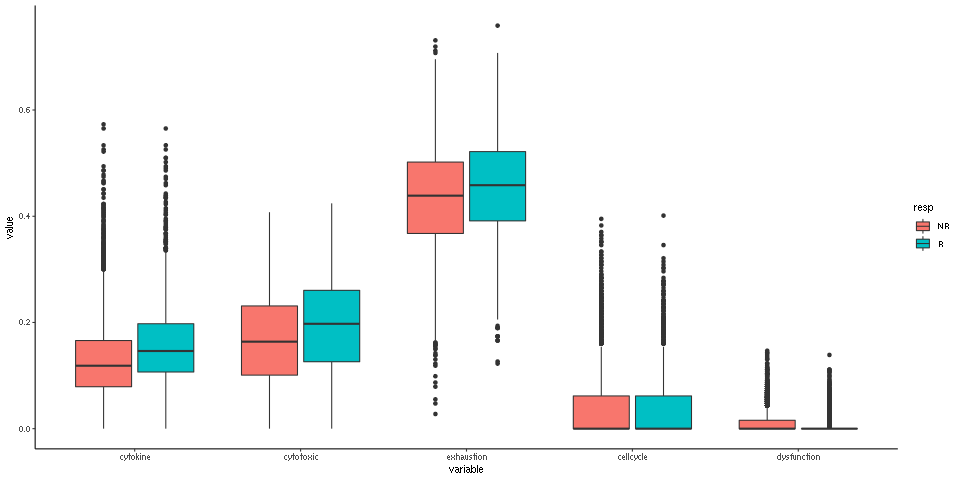

In [121]:
%%R -w 960 -h 480 -u px

auc_data <- getAUC(all_signatures)
a <- data.frame(auc_data[, data.cd8$response_1month_2category == "NR"])
b <- data.frame(auc_data[, data.cd8$response_1month_2category == "R"])

t_a <- t(a)
t_a <- data.frame(t_a)
t_a$resp <- "NR"
t_a <- melt(t_a)
t_b <- t(b)
t_b <- data.frame(t_b)
t_b$resp <- "R"
t_b <- melt(t_b)

t_ab <- rbind(t_a, t_b)

ggplot(data.frame(t_ab), aes(x=variable, y=value, fill=resp)) + 
    geom_boxplot() +
    theme_classic()

R[write to console]: Using resp as id variables

R[write to console]: Using resp as id variables



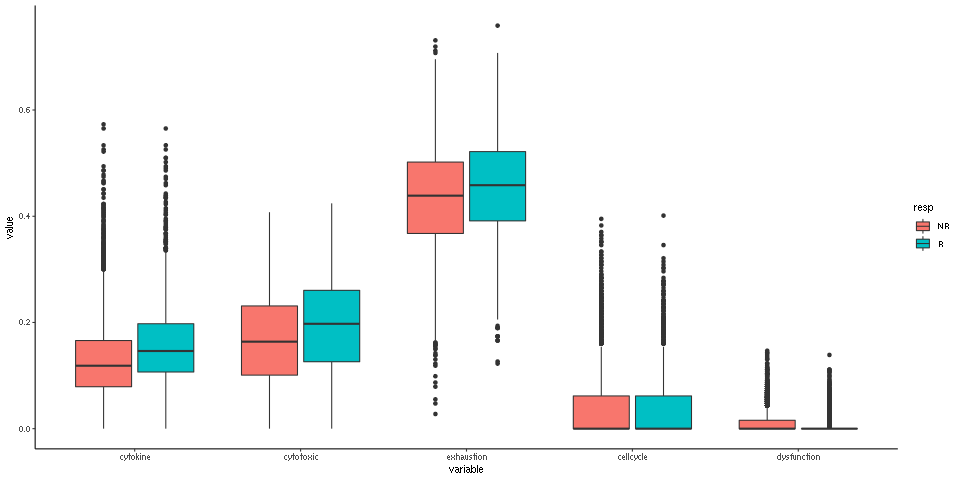

In [126]:
%%R -w 960 -h 480 -u px

auc_data <- getAUC(all_signatures)
auc_NR <- data.frame(t(auc_data[, data.cd8$response_1month_2category == "NR"]))
auc_R <- data.frame(t(auc_data[, data.cd8$response_1month_2category == "R"]))

auc_NR$resp <- "NR"
auc_NR <- melt(auc_NR)
auc_R$resp <- "R"
auc_R <- melt(auc_R)

auc_melt <- rbind(auc_NR, auc_R)

ggplot(data.frame(auc_melt), aes(x=variable, y=value, fill=resp)) + 
    geom_boxplot() +
    theme_classic()

Testing differences in AUCell scores between NR/R:

In [124]:
%%R

t_ab$value <- t_ab$value + 1e-9
t_ab$logvalue <- log2(t_ab$value)

print(oneway.test(logvalue~resp, data = t_ab[t_ab$variable=="cytokine",], var.equal = FALSE))
print(oneway.test(logvalue~resp, data = t_ab[t_ab$variable=="cytotoxic",], var.equal = FALSE))
print(oneway.test(logvalue~resp, data = t_ab[t_ab$variable=="exhaustion",], var.equal = FALSE))
print(oneway.test(logvalue~resp, data = t_ab[t_ab$variable=="cellcycle",], var.equal = FALSE))
print(oneway.test(logvalue~resp, data = t_ab[t_ab$variable=="dysfunction",], var.equal = FALSE))


	One-way analysis of means (not assuming equal variances)

data:  logvalue and resp
F = 35.379, num df = 1.0, denom df = 4712.9, p-value = 2.91e-09


	One-way analysis of means (not assuming equal variances)

data:  logvalue and resp
F = 18.192, num df = 1.0, denom df = 4298.9, p-value = 2.04e-05


	One-way analysis of means (not assuming equal variances)

data:  logvalue and resp
F = 58.151, num df = 1.0, denom df = 4034.5, p-value = 3.009e-14


	One-way analysis of means (not assuming equal variances)

data:  logvalue and resp
F = 4.6857, num df = 1.0, denom df = 3698.5, p-value = 0.03048


	One-way analysis of means (not assuming equal variances)

data:  logvalue and resp
F = 34.719, num df = 1, denom df = 4029, p-value = 4.12e-09



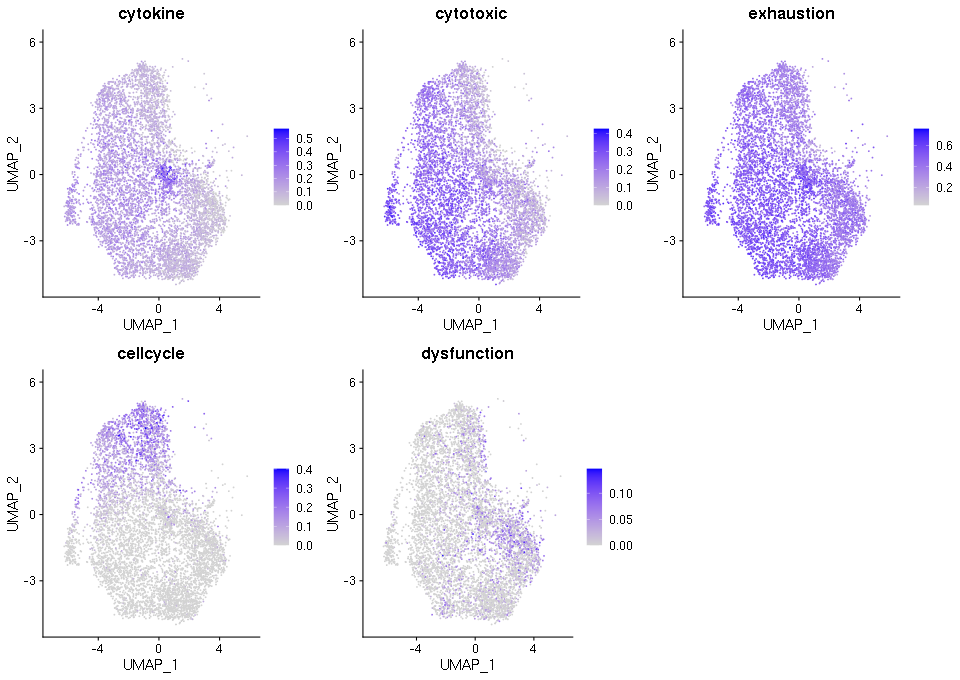

In [106]:
%%R -w 960 -h 680 -u px

data.cd8$cytokine <- data.frame(t(auc_data))$cytokine
data.cd8$cytotoxic <- data.frame(t(auc_data))$cytotoxic
data.cd8$exhaustion <- data.frame(t(auc_data))$exhaustion
data.cd8$cellcycle <- data.frame(t(auc_data))$cellcycle
data.cd8$dysfunction <- data.frame(t(auc_data))$dysfunction

a <- FeaturePlot(data.cd8, features="cytokine")
b <- FeaturePlot(data.cd8, features="cytotoxic")
c <- FeaturePlot(data.cd8, features="exhaustion")
d <- FeaturePlot(data.cd8, features="cellcycle")
e <- FeaturePlot(data.cd8, features="dysfunction")

grid.arrange(a, b, c, d, e, nrow = 2)

In [90]:
%%R

sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/claudio/anaconda3/envs/M_Essand_2101/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=sv_SE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=sv_SE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=sv_SE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=sv_SE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] AUCell_1.19.1         abind_1.4-5           readxl_1.3.1         
 [4] EnhancedVolcano_1.6.0 ggrepel_0.9.1         reshape2_1.4.4       
 [7] SeuratDisk_0.0.0.9019 dplyr_1.0.5           pheatmap_1.0.12      
[10] plyr_1.8.6            ggplot2_3.3.3         gridEx